#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05

In [18]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt

from skranger.ensemble import RangerForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

ModuleNotFoundError: No module named 'skranger'

## PART I
### Loading and preparing data 
----------------------------------------------

In [2]:
area = "bangkok"
data = pd.read_csv("../data/airbnb_" + area + "_workfile.csv")
data = data.loc[data.price.notna(), :]

In [3]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum()>0]

In [4]:
count_missing_values(data)

Series([], dtype: int64)

In [5]:
# Sample definition and preparation ---------------------------------------

# We focus on normal apartments, n<8
data = data.query('2 <= n_accommodates <= 6')

In [6]:
# copy a variable - purpose later, see at variable importance
data = data.assign(n_accommodates_copy = data.n_accommodates)

In [7]:

# basic descr stat -------------------------------------------
data.describe()

usd_price_day  p_host_response_rate  n_accommodates  \
count    3627.000000                3627.0     3627.000000   
mean      679.064792                   0.0        2.586986   
std       194.503709                   0.0        0.883648   
min       269.000000                   0.0        2.000000   
25%       500.000000                   0.0        2.000000   
50%       699.000000                   0.0        2.000000   
75%       850.000000                   0.0        3.000000   
max       999.000000                   0.0        6.000000   

       n_review_scores_rating  n_number_of_reviews  n_reviews_per_month  \
count             3627.000000          3627.000000          3627.000000   
mean                 4.663774            20.970499             0.666981   
std                  0.542642            42.424963             0.805605   
min                  0.000000             0.000000             0.010000   
25%                  4.650000             1.000000             0.220000   
50%                  4.770000             4.000000             0.430000   
75%                  4.900000            21.000000             0.780000   
max                  5.000000           443.000000            15.370000   

       n_minimum_nights       n_beds  n_days_since  d_airconditioning  ...  \
count       3627.000000  3627.000000   3627.000000        3627.000000  ...   
mean          17.510339     1.237938    910.653708           0.979322  ...   
std           44.203518     0.617286    508.824030           0.142324  ...   
min            1.000000     0.000000      1.000000           0.000000  ...   
25%            1.000000     1.000000    634.000000           1.000000  ...   
50%            2.000000     1.000000    790.000000           1.000000  ...   
75%           28.000000     1.000000    982.000000           1.000000  ...   
max          730.000000     6.000000   3848.000000           1.000000  ...   

       flag_review_scores_rating  flag_reviews_per_month  \
count                3627.000000             3627.000000   
mean                    0.245106                0.245106   
std                     0.430209                0.430209   
min                     0.000000                0.000000   
25%                     0.000000                0.000000   
50%                     0.000000                0.000000   
75%                     0.000000                0.000000   
max                     1.000000                1.000000   

       flag_n_number_of_reviews  ln_days_since  ln_days_since2  \
count                    3627.0    3627.000000     3627.000000   
mean                        0.0       6.649400       44.644182   
std                         0.0       0.655580        7.964334   
min                         0.0       0.693147        0.480453   
25%                         0.0       6.453625       41.649276   
50%                         0.0       6.673298       44.532906   
75%                         0.0       6.890609       47.480494   
max                         0.0       8.255569       68.154414   

       ln_days_since3  n_days_since2  n_days_since3  ln_review_scores_rating  \
count     3627.000000   3.627000e+03   3.627000e+03              3627.000000   
mean       302.018658   1.088121e+06   1.658374e+09                     -inf   
std         76.233420   1.373715e+06   3.530946e+09                      NaN   
min          0.333025   1.000000e+00   1.000000e+00                     -inf   
25%        268.788806   4.019560e+05   2.548401e+08                 1.536867   
50%        297.181350   6.241000e+05   4.930390e+08                 1.562346   
75%        327.169525   9.643240e+05   9.469662e+08                 1.589235   
max        562.653442   1.480710e+07   5.697774e+10                 1.609438   

       n_accommodates_copy  
count          3627.000000  
mean              2.586986  
std               0.883648  
min               2.000000  
25%               2.000000  
50%               2.000000  
75%      

In [8]:
data.price.describe()

count    3627.000000
mean      679.064792
std       194.503709
min       269.000000
25%       500.000000
50%       699.000000
75%       850.000000
max       999.000000
Name: price, dtype: float64

In [10]:
data.f_property_type.value_counts()

Entire rental unit            1983
Entire condominium (condo)    1577
Entire serviced apartment       67
Name: f_property_type, dtype: int64

In [11]:
data.f_number_of_reviews.value_counts()

1    2304
0     889
2     434
Name: f_number_of_reviews, dtype: int64

In [12]:
# create train and holdout samples -------------------------------------------
# train is where we do it all, incl CV

# First pick a smaller than usual training set so that models run faster and check if works
# If works, start anew without these two lines

In [13]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

In [14]:
data_train.shape, data_holdout.shape

((2538, 89), (1089, 89))

In [40]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# Dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "n_accommodates:d_longtermstaysallowed",
    "d_breakfast:f_property_type",
    "d_kitchen:f_property_type",
    "d_elevator:f_property_type",
    "d_essentials:f_property_type"
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    #"f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [38]:
data.d_bathtub.value_counts()

0    3508
1     119
Name: d_bathtub, dtype: int64

In [43]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

## PART II
### RANDOM FORESTS 
-------------------------------------------------------

In [44]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [5, 7, 9], "min_node_size": [5, 10]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_1), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())

NameError: name 'RangerForestRegressor' is not defined

In [19]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .........min_node_size=5, mtry=8;, score=-44.952 total time=   9.3s
[CV 2/5] END .........min_node_size=5, mtry=8;, score=-43.998 total time=   8.2s
[CV 3/5] END .........min_node_size=5, mtry=8;, score=-44.870 total time=   7.6s
[CV 4/5] END .........min_node_size=5, mtry=8;, score=-42.269 total time=   7.8s
[CV 5/5] END .........min_node_size=5, mtry=8;, score=-45.505 total time=   7.9s
[CV 1/5] END ........min_node_size=5, mtry=10;, score=-44.654 total time=   9.1s
[CV 2/5] END ........min_node_size=5, mtry=10;, score=-43.731 total time=   9.3s
[CV 3/5] END ........min_node_size=5, mtry=10;, score=-44.620 total time=   9.1s
[CV 4/5] END ........min_node_size=5, mtry=10;, score=-41.975 total time=   9.1s
[CV 5/5] END ........min_node_size=5, mtry=10;, score=-45.216 total time=   9.0s
[CV 1/5] END ........min_node_size=5, mtry=12;, score=-44.550 total time=  10.6s
[CV 2/5] END ........min_node_size=5, mtry=12;, s

### Table 16.1 Random forest RMSE by tuning parameters

In [20]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables     8      10     12
Min_nodes                     
5          44.32  44.04  43.83
10         44.45  44.07  43.90
15         44.61  44.23  44.15

In [21]:
pd.DataFrame(
    {
        "Min vars": [rf_model_1.best_estimator_.mtry, rf_model_2.best_estimator_.mtry],
        "Min nodes": [
            rf_model_1.best_estimator_.min_node_size,
            rf_model_2.best_estimator_.min_node_size,
        ],
    },
    ["Model A", "Model B"],
)

Min vars  Min nodes
Model A         7          5
Model B        12          5

In [22]:
pd.DataFrame(
    {
        "RMSE": [
            rf_model_1.cv_results_["mean_test_score"].min(),
            rf_model_2.cv_results_["mean_test_score"].min(),
        ]
    },
    ["Model A", "Model B"],
).round(3) * -1

RMSE
Model A  46.247
Model B  44.606

## PART III
### MODEL DIAGNOSTICS 
---

In [23]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname",0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

**1) full varimp plot, above a cutoff**

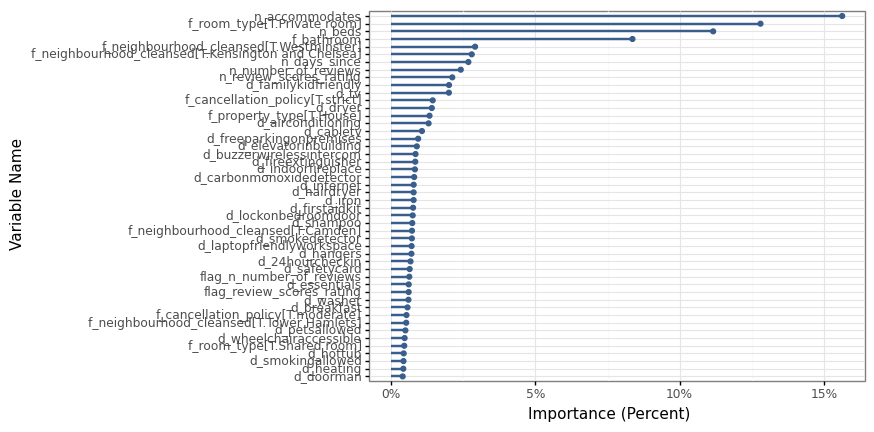

<ggplot: (333843984)>

In [24]:
cutoff = 600000

ggplot(
    rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**2) full varimp plot, top 10 only**

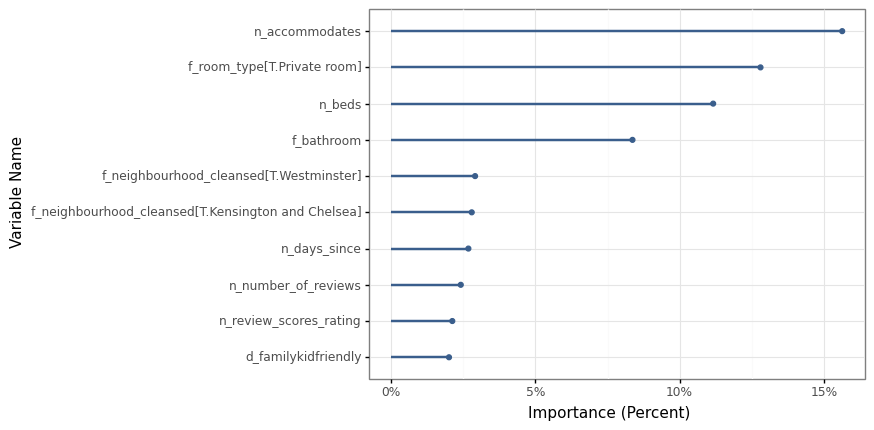

<ggplot: (334030150)>

In [25]:
ggplot(
    rf_model_2_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**3) grouped variable importance - keep binaries created off factors together**

For this, you need to create an sklearn pipeline and put OneHotEncoding in it (before, encoding was done by patsy's dmatrices). This way permutation_importance can calculate factor variables' importance 

In [26]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [27]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_model_2.best_estimator_)] # put best model to pipeline
)

In [28]:
rf.fit(data_train[predictors_2],data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_r...
      

In [29]:
# this takes a while to run
result = permutation_importance(
    rf,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
)

In [30]:
grouped = [
    "f_bed_type",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
    "f_cancellation_policy",
]
grouped_imp = (
    pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns,
    )
    .loc[grouped]
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

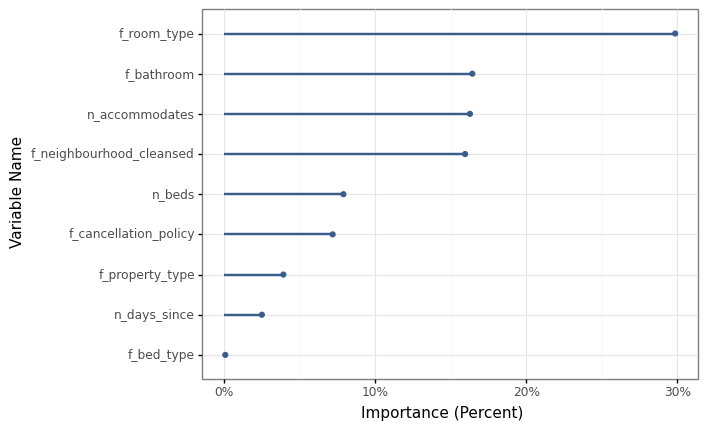

<ggplot: (333833340)>

In [31]:
ggplot(grouped_imp, aes(x="reorder(varname, imp)", y="imp_percentage"),) + geom_point(
    color=color[0], size=1.5
) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), color=color[0], size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

## Partial Dependence Plots 
-------------------------------------------------------


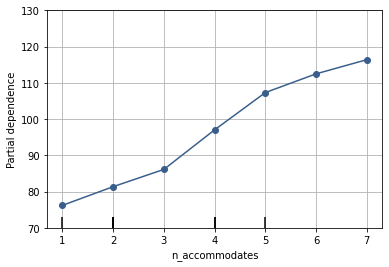

In [32]:
# Note: easy way, sklearn has plot_partial_dependence function
# we do this on holdout set!
plot_partial_dependence(
    rf,
    data_holdout[predictors_2],
    ["n_accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": color[0]},
)
plt.grid()
plt.ylim(70, 130)
plt.show()

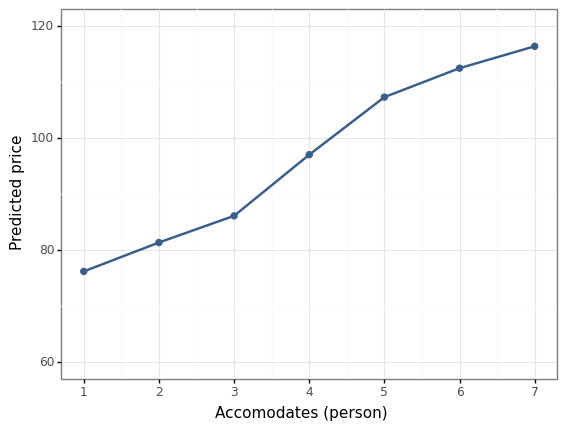

<ggplot: (334069020)>

In [33]:
# replicate the exact book figure with plotnine
accom_pdp = partial_dependence(
    rf, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)

ggplot(accom_pdp, aes(x="Accomodates (person)", y="Predicted price")) + geom_point(
    color=color[0], size=2
) + geom_line(color=color[0], size=1) + ylim(60, 120) + scale_x_continuous(
    breaks=range(1, 8)
) + theme_bw()

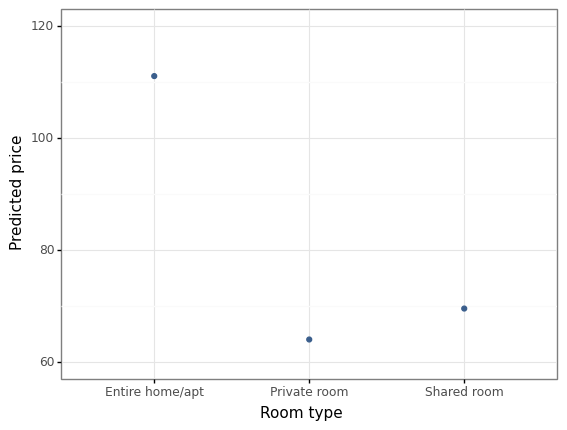

<ggplot: (334064556)>

In [34]:
roomtype_pdp = partial_dependence(
    rf, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

roomtype_pdp = (
    pd.DataFrame(roomtype_pdp["average"], columns=roomtype_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Room type"}, axis=1)
)

ggplot(roomtype_pdp, aes(x="Room type", y="Predicted price")) + geom_point(
    color=color[0]
) + ylim(60, 120) + theme_bw()

### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [35]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf.predict(data_holdout[predictors_2])
)

create nice summary table of heterogeneity

In [36]:
from sklearn.metrics import mean_squared_error


def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [37]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [38]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

In [39]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

In [40]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
all_holdout.index = ["All"]

In [41]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

### Table 16.2 Performance across subsamples

In [42]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        all_holdout,
    ]
)

rmse mean_price rmse_norm
Apartment size                                        
large apt                    64.9     144.06      0.45
small apt                   30.81      62.86      0.49
Type                                                  
Apartment                   42.81      93.19      0.46
House                       50.25      77.49      0.65
Borough                                               
Camden                      52.09     105.01       0.5
Hackney                      38.6      76.05      0.51
Kensington and Chelsea      65.37     143.55      0.46
Newham                      29.34      61.57      0.48
Tower Hamlets               34.73      74.25      0.47
Westminster                 63.92     131.43      0.49
All                     44.809766  89.212336  0.502282

## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------
**NOTE: this part of the code is not finished**

1. OLS with dummies for area

 using model B

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [46]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

157.04410229200752

In [47]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [48]:
ols_model_coeffs_df

ols_coefficient
Intercept                                               0.000
f_property_type[T.Entire rental unit]                  11.811
f_property_type[T.Entire serviced apartment]           50.540
f_neighbourhood_cleansed[T.Bang Khae]                -100.439
f_neighbourhood_cleansed[T.Bang Khen]                 -45.909
...                                                       ...
d_hotwaterkettle                                       34.539
d_keypad                                               13.671
d_bathtub                                              44.927
d_singlelevelhome                                      53.860
d_paidparkingoffpremises                              -41.504

[111 rows x 1 columns]

2.  LASSO

using extended model w interactions

In [49]:
from sklearn.linear_model import ElasticNet

The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [50]:
lasso_model =  ElasticNet(l1_ratio = 1,normalize=True,fit_intercept=True)

In [51]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [52]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [53]:
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... alpha=0.01, score=-172.708, total=   0.3s
[CV] alpha=0.01 ......................................................
[CV] ....................... alpha=0.01, score=-162.493, total=   0.2s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ....................... alpha=0.01, score=-163.747, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................... alpha=0.01, score=-161.200, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] ....................... alpha=0.01, score=-166.638, total=   0.1s
[CV] alpha=0.02 ......................................................
[CV] ....................... alpha=0.02, score=-172.322, total=   0.1s
[CV] alpha=0.02 ......................................................
[CV] ....................... alpha=0.02, score=-163.089, total=   0.1s
[CV] alpha=0.02 ......................................................
[CV] ....................... alpha=0.02, score=-163.433, total=   0.1s
[CV] alpha=0.02 ......................................................
[CV] ....................... alpha=0.02, score=-160.484, total=   0.1s
[CV] alpha=0.02 ......................................................
[CV] .

[CV] ....................... alpha=0.13, score=-174.416, total=   0.0s
[CV] alpha=0.13 ......................................................
[CV] ....................... alpha=0.13, score=-166.117, total=   0.0s
[CV] alpha=0.13 ......................................................
[CV] ....................... alpha=0.13, score=-162.218, total=   0.0s
[CV] alpha=0.13 ......................................................
[CV] ....................... alpha=0.13, score=-164.799, total=   0.0s
[CV] alpha=0.13 ......................................................
[CV] ....................... alpha=0.13, score=-163.771, total=   0.0s
[CV] alpha=0.14 ......................................................
[CV] ....................... alpha=0.14, score=-174.733, total=   0.0s
[CV] alpha=0.14 ......................................................
[CV] ....................... alpha=0.14, score=-166.460, total=   0.0s
[CV] alpha=0.14 ......................................................
[CV] .

[CV] ....................... alpha=0.24, score=-169.676, total=   0.0s
[CV] alpha=0.24 ......................................................
[CV] ....................... alpha=0.24, score=-169.864, total=   0.0s
[CV] alpha=0.25 ......................................................
[CV] ....................... alpha=0.25, score=-178.660, total=   0.0s
[CV] alpha=0.25 ......................................................
[CV] ....................... alpha=0.25, score=-169.902, total=   0.0s
[CV] alpha=0.25 ......................................................
[CV] ....................... alpha=0.25, score=-165.212, total=   0.0s
[CV] alpha=0.25 ......................................................
[CV] ....................... alpha=0.25, score=-169.968, total=   0.0s
[CV] alpha=0.25 ......................................................
[CV] ....................... alpha=0.25, score=-170.478, total=   0.0s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    5.3s finished


GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1, normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
                                   0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                                   0.22, 0.23, 0.24, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [54]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

lasso_coefficient
f_neighbourhood_cleansed[T.Bang Khae]                  -45.069
f_neighbourhood_cleansed[T.Bang Kho laen]                0.200
f_neighbourhood_cleansed[T.Bang Khun thain]             -4.585
f_neighbourhood_cleansed[T.Bang Na]                    -27.460
f_neighbourhood_cleansed[T.Bang Phlat]                 -81.722
...                                                        ...
d_hotwaterkettle                                         9.603
d_keypad                                                 0.408
d_bathtub                                               40.910
d_singlelevelhome                                       48.073
d_paidparkingoffpremises                               -26.326

[107 rows x 1 columns]

In [55]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

164.21569656046614

3. CART model

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [58]:
cart_model = DecisionTreeClassifier(random_state=2018, criterion="gini")

In [59]:
# Get potential ccp_alpha parameters

path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [60]:
# apply random search to select a "best" alpha 
# RandomizedSearchCV does not calculate all potential alphas, just a random subset

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] ccp_alpha=0.0007092198581560284 .................................
[CV] .. ccp_alpha=0.0007092198581560284, score=-237.990, total=   0.1s
[CV] ccp_alpha=0.0007092198581560284 .................................


/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. ccp_alpha=0.0007092198581560284, score=-207.990, total=   0.1s
[CV] ccp_alpha=0.0007092198581560284 .................................
[CV] .. ccp_alpha=0.0007092198581560284, score=-233.176, total=   0.1s
[CV] ccp_alpha=0.0007092198581560284 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .. ccp_alpha=0.0007092198581560284, score=-224.929, total=   0.1s
[CV] ccp_alpha=0.0007092198581560284 .................................
[CV] .. ccp_alpha=0.0007092198581560284, score=-231.468, total=   0.1s
[CV] ccp_alpha=0.0005122143420015759 .................................
[CV] .. ccp_alpha=0.0005122143420015759, score=-255.902, total=   0.1s
[CV] ccp_alpha=0.0005122143420015759 .................................
[CV] .. ccp_alpha=0.0005122143420015759, score=-226.656, total=   0.1s
[CV] ccp_alpha=0.0005122143420015759 .................................
[CV] .. ccp_alpha=0.0005122143420015759, score=-236.844, total=   0.1s
[CV] ccp_alpha=0.0005122143420015759 .................................
[CV] .. ccp_alpha=0.0005122143420015759, score=-243.442, total=   0.1s
[CV] ccp_alpha=0.0005122143420015759 .................................
[CV] .. ccp_alpha=0.0005122143420015759, score=-242.536, total=   0.2s
[CV] ccp_alpha=0.0003940110323089047 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.8s finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2018),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 6.56685054e-05, 1.31337011e-04, 1.31337011e-04,
       1.31337011e-04, 1.50099441e-04, 1.97005516e-04, 2.62674022e-04,
       2.95508274e-04, 2.95508274e-04, 2.95508274e-04, 2.95508274e-04,
       2.95508274e-04, 3.06453025e-04, 3.15208826e-04, 3.1520882...
       1.32212591e-03, 1.33547229e-03, 1.39162408e-03, 1.40546618e-03,
       1.41439858e-03, 1.41754291e-03, 1.43362893e-03, 1.49597772e-03,
       1.55589502e-03, 1.68031101e-03, 1.74021539e-03, 1.79229650e-03,
       2.18971992e-03, 2.30838026e-03, 2.41732562e-03, 2.42469024e-03,
       2.86484888e-03, 3.87891405e-03, 4.36998259e-03, 4.70288338e-03,
       6.81983312e-03, 7.10191545e-03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [61]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

212.8151612421199

4. GBM

**NOTE:** These models run for a **very long time** -- needs further investigations.

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbm = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=20)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [ ]:
gbm_pipe.fit(data_train[predictors_2],data_train.price)

the next will be in final model, loads of tuning

In [ ]:
gbm_broad = GradientBoostingClassifier()

In [ ]:
tune_grid = {
    "n_estimators": [i for i in range(50, 500, 50)],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.02, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm2,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
)

In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)

In [ ]:
gbm_pipe_broad.fit(data_train[predictors_2],data_train.price)